<a href="https://colab.research.google.com/github/Welle-Kim/Python/blob/master/RNN%26LSTM%EC%9D%84_%ED%99%9C%EC%9A%A9%ED%95%9C_%EC%98%81%ED%99%94_%EB%A6%AC%EB%B7%B0_%EA%B8%8D%EB%B6%80%EC%A0%95_%EB%B6%84%EB%A5%98_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 필요 라이브러리 설치

In [ ]:
!apt-get update
!apt-get install g++ openjdk-8-jdk
!pip3 install konlpy

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 3,626 B in 2s (2,012 B/s)
Reading package lists... Done
Reading

# 라이브러리 import, 데이터 셋 다운로드

Tokenizer
- 사전에 있는 단어의 순서에 맞게 단어를 turning하면서 말뭉치를 벡터화

In [ ]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
from konlpy.tag import Okt
import numpy as np
import re

okt = Okt()

In [ ]:
# 학습/테스트 데이터 받아오기
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", 
                           filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", 
                           filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f9b15db9790>)

# 데이터셋 살펴보기(EDA)

In [ ]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [ ]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 텍스트 전처리

In [ ]:
# 중복 제거를 위한 중복 체크
# 유니크한 value의 개수를 나타냄
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [ ]:
test_data['document'].nunique(), test_data['label'].nunique() 

(49157, 2)

In [ ]:
train_data.drop_duplicates(subset=['document'], 
                           inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거

In [ ]:
test_data.drop_duplicates(subset=['document'], 
                           inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거

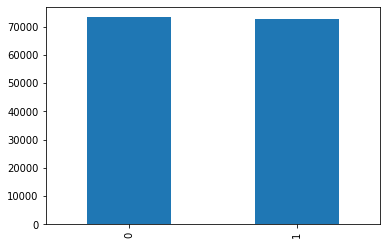

In [ ]:
# label 데이터 구성 확인
train_data['label'].value_counts().plot(kind = 'bar')

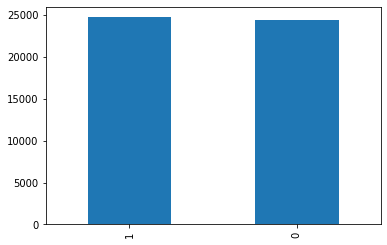

In [ ]:
test_data['label'].value_counts().plot(kind = 'bar')

In [ ]:
# nan 값 존재 여부 확인
train_data.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [ ]:
test_data.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [ ]:
print(train_data.loc[train_data.document.isnull()])
print(test_data.loc[test_data.document.isnull()])

            id document  label
25857  2172111      NaN      1
          id document  label
5746  402110      NaN      1


In [ ]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print('학습용:', train_data.isnull().values.any()) # Null 값이 존재하는지 확인

학습용: False


In [ ]:
test_data = test_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print('테스트:', test_data.isnull().values.any()) # Null 값이 존재하는지 확인

테스트: False


In [ ]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [ ]:
# 정규식 표현법을 이용한 데이터 정리(한글만 남겨두기)
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['document']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


0                                         아 더빙 진짜 짜증나네요 목소리
1                                흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                                 교도소 이야기구먼 솔직히 재미는 없다평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...
                                ...                        
149995                                      인간이 문제지 소는 뭔죄인가
149996                                           평점이 너무 낮아서
149997                        이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다
149998                           청춘 영화의 최고봉방황과 우울했던 날들의 자화상
149999                             한국 영화 최초로 수간하는 내용이 담긴 영화
Name: document, Length: 146182, dtype: object

In [ ]:
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['document']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


0                                               굳 ㅋ
1                                                  
2                  뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아
3                         지루하지는 않은데 완전 막장임 돈주고 보기에는
4         만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠
                            ...                    
49995     오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함
49996      의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 
49997               그림도 좋고 완성도도 높았지만 보는 내내 불안하게 만든다
49998    절대 봐서는 안 될 영화 재미도 없고 기분만 잡치고 한 세트장에서 다 해먹네
49999                                    마무리는 또 왜이래
Name: document, Length: 49157, dtype: object

In [ ]:
# stopword를 이용한 불용어 처리
# https://www.ranks.nl/stopwords/korean

from google.colab import files
myfile = files.upload()

Saving korean_stopword.csv to korean_stopword.csv


In [ ]:
k_stopword = pd.read_csv('korean_stopword.csv',encoding="cp949")
k_stopword.head()

,불용어,Unnamed: 1,Unnamed: 2
0,아,어찌_든,하기보다는
1,휴,그위에,차라리
2,아이구,게다가,하는 편이 낫다
3,아이쿠,점에서 보아,흐흐
4,아이고,비추어 보아,놀라다


In [ ]:
# 기본 제공된 불용어에 사용자가 필요한 불용어 추가
stopword = list(k_stopword['불용어'])+['을','은','를','이가','과','의','는','에']
stopword[-10:]

['된이상', '만큼', '을', '은', '를', '이가', '과', '의', '는', '에']

In [ ]:
X_train = []
for i in train_data.index:
    morph = okt.morphs(train_data.loc[i]['document'])
    temp_X = []
    for txt in morph:
      if txt not in stopword:
       temp_X.append(txt)
    X_train.append(temp_X)
X_train[:5]

[['더빙', '진짜', '짜증나네요', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍지', '않구나'],
 ['너', '무재', '밓었', '다그', '래서', '보는것을', '추천', '한', '다'],
 ['교도소', '이야기', '구먼', '솔직히', '재미', '없다', '평점', '조정'],
 ['사이',
  '몬페',
  '그',
  '익살스런',
  '연기',
  '돋보였던',
  '영화',
  '스파이더맨',
  '에서',
  '늙어',
  '보이기만',
  '했던',
  '커스틴',
  '던스트',
  '너무나도',
  '이뻐',
  '보였다']]

In [ ]:
# 빈 샘플 제거
drop_train = []
for index, sentence in enumerate(X_train):
  if len(sentence) < 1:
    drop_train.append(index)
drop_train[:3]

[151, 404, 412]

In [ ]:
y_train = np.array(train_data['label'])
y_train[:6]

array([0, 1, 0, 0, 1, 0])

In [ ]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145315
145315


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [ ]:
X_test = []
for i in test_data.index:
    morph = okt.morphs(test_data.loc[i]['document'])
    temp_X = []
    for txt in morph:
      if txt not in stopword:
       temp_X.append(txt)
    X_test.append(temp_X)
X_test[:5]

[['굳', 'ㅋ'],
 [],
 ['뭐', '이', '평점', '들', '나쁘진', '않지만', '점', '짜', '리', '더', '더욱', '아니잖아'],
 ['지루하지는', '않은데', '완전', '막장', '임', '돈', '주고', '보기', '에는'],
 ['만', '아니었어도', '별', '다섯', '개', '줬을텐데', '나와서', '심기', '불편하게', '하죠']]

In [ ]:
# 빈 샘플 제거
drop_test = []
for index, sentence in enumerate(X_test):
  if len(sentence) < 1:
    drop_test.append(index)
drop_test[:3]

[1, 116, 254]

In [ ]:
y_test = np.array(test_data['label'])
y_test[:6]

array([1, 0, 0, 0, 0, 1])

In [ ]:
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)
print(len(X_test))
print(len(y_test))

48815
48815


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


# 토큰화

In [ ]:
# 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
print(tokenizer.word_index)

{'이': 1, '영화': 2, '도': 3, '들': 4, '너무': 5, '한': 6, '다': 7, '정말': 8, '적': 9, '만': 10, '진짜': 11, '점': 12, '에서': 13, '연기': 14, '것': 15, '평점': 16, '내': 17, '최고': 18, '그': 19, '잘': 20, '안': 21, '인': 22, '이런': 23, '스토리': 24, '생각': 25, '못': 26, '드라마': 27, '게': 28, '이다': 29, '감동': 30, '사람': 31, '보고': 32, '하는': 33, '하고': 34, '말': 35, '고': 36, '더': 37, '배우': 38, '때': 39, 'ㅋㅋ': 40, '감독': 41, '거': 42, '그냥': 43, '본': 44, '요': 45, '재미': 46, '시간': 47, '내용': 48, '뭐': 49, '중': 50, '보다': 51, '없는': 52, '쓰레기': 53, '수': 54, '네': 55, '지': 56, '봤는데': 57, '작품': 58, '사랑': 59, '할': 60, '하나': 61, '다시': 62, '없다': 63, '볼': 64, '마지막': 65, '좋은': 66, '이건': 67, '정도': 68, '같은': 69, '완전': 70, '입니다': 71, '있는': 72, 'ㅋ': 73, 'ㅠㅠ': 74, '처음': 75, 'ㅋㅋㅋ': 76, '장면': 77, '액션': 78, '주인공': 79, '걸': 80, '이렇게': 81, '보는': 82, '개': 83, '최악': 84, '돈': 85, '이야기': 86, '지금': 87, '봐도': 88, '느낌': 89, '참': 90, '임': 91, '연출': 92, 'ㅡㅡ': 93, '라': 94, '인데': 95, '없고': 96, '듯': 97, '끝': 98, '명작': 99, '년': 100, '별로': 101, '역시': 102, '기': 103, '많이':

In [ ]:
len(tokenizer.word_index)

99886

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 99886
등장 빈도가 2번 이하인 희귀 단어의 수: 67671
단어 집합에서 희귀 단어의 비율: 67.74823298560358
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.86929742503171


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 32217


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train[:3]

[[399, 12, 6523, 596],
 [872, 401, 33, 541, 3, 171, 1478, 15, 905, 5962, 25690],
 [341, 2754, 1, 2589, 7250, 11944, 176, 7, 8]]

In [ ]:
tokenizer.word_index

{'OOV': 1,
 '이': 2,
 '영화': 3,
 '도': 4,
 '들': 5,
 '너무': 6,
 '한': 7,
 '다': 8,
 '정말': 9,
 '적': 10,
 '만': 11,
 '진짜': 12,
 '점': 13,
 '에서': 14,
 '연기': 15,
 '것': 16,
 '평점': 17,
 '내': 18,
 '최고': 19,
 '그': 20,
 '잘': 21,
 '안': 22,
 '인': 23,
 '이런': 24,
 '스토리': 25,
 '생각': 26,
 '못': 27,
 '드라마': 28,
 '게': 29,
 '이다': 30,
 '감동': 31,
 '사람': 32,
 '보고': 33,
 '하는': 34,
 '하고': 35,
 '말': 36,
 '고': 37,
 '더': 38,
 '배우': 39,
 '때': 40,
 'ㅋㅋ': 41,
 '감독': 42,
 '거': 43,
 '그냥': 44,
 '본': 45,
 '요': 46,
 '재미': 47,
 '시간': 48,
 '내용': 49,
 '뭐': 50,
 '중': 51,
 '보다': 52,
 '없는': 53,
 '쓰레기': 54,
 '수': 55,
 '네': 56,
 '지': 57,
 '봤는데': 58,
 '작품': 59,
 '사랑': 60,
 '할': 61,
 '하나': 62,
 '다시': 63,
 '없다': 64,
 '볼': 65,
 '마지막': 66,
 '좋은': 67,
 '이건': 68,
 '정도': 69,
 '같은': 70,
 '완전': 71,
 '입니다': 72,
 '있는': 73,
 'ㅋ': 74,
 'ㅠㅠ': 75,
 '처음': 76,
 'ㅋㅋㅋ': 77,
 '장면': 78,
 '액션': 79,
 '주인공': 80,
 '걸': 81,
 '이렇게': 82,
 '보는': 83,
 '개': 84,
 '최악': 85,
 '돈': 86,
 '이야기': 87,
 '지금': 88,
 '봐도': 89,
 '느낌': 90,
 '참': 91,
 '임': 92,
 '연출': 93,
 'ㅡㅡ': 94,


In [ ]:
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

리뷰의 평균 길이 : 11.409703058872106


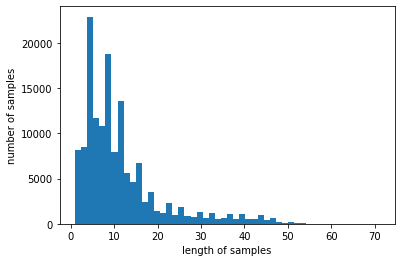

In [ ]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 93.51271375976327


## 데이터 길이 맞추기

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train = pad_sequences(X_train, maxlen = max_len)
X_train[:3]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,   399,
           12,  6523,   596],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,   872,   401,    33,   541,     3,   171,  1478,    15,
          905,  5962, 25690],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   341,  2754,     1,  2589,  7250, 11944,
          176,     7,     8]], dtype=int32)

In [ ]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = max_len)
X_test.shape

(48815, 30)

In [ ]:
vocab_size

32217

# RNN을 이용한 학습

In [ ]:
# RNN 
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model_RNN = Sequential()
model_RNN.add(Embedding(input_dim = vocab_size, output_dim = 128))
model_RNN.add(SimpleRNN(128, return_sequences = True))
model_RNN.add(SimpleRNN(64, return_sequences = False))
model_RNN.add(Dense(1, activation='sigmoid'))


# model_RNN = Sequential([
#     Embedding(input_dim = vocab_size, output_dim = 128),
#     SimpleRNN(128, return_sequences = True),
#     SimpleRNN(64, return_sequences = False),
#     Dense(1, activation='sigmoid')
#     ])

In [ ]:
model_RNN.compile(optimizer='rmsprop',
             loss = 'binary_crossentropy',
             metrics = ['acc'])

model_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         4123776   
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 128)         32896     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 4,169,089
Trainable params: 4,169,089
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 검증 데이터 손실(val_loss)이 증가하면, 
# 과적합 징후므로 검증 데이터 손실이 4회 증가하면 
# 학습을 조기 종료(Early Stopping)합니다. 
es = EarlyStopping(monitor='val_loss', 
                   mode='min', verbose=1, patience=4)
# ModelCheckpoint를 사용하여 검증 데이터의 
# 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장합니다.
mc = ModelCheckpoint('best_model_RNN.h5', 
                     monitor='val_acc', mode='max', 
                     verbose=2, save_best_only=True)

In [ ]:
history = model_RNN.fit(X_train, y_train, 
                    epochs=10, 
                    callbacks=[es, mc], 
                    batch_size=60, 
                    validation_split=0.2)

Epoch 1/10
1938/1938 [==============================] - ETA: 0s - loss: 0.4425 - acc: 0.7852
Epoch 1: val_acc improved from -inf to 0.82459, saving model to best_model_RNN.h5
1938/1938 [==============================] - 118s 58ms/step - loss: 0.4425 - acc: 0.7852 - val_loss: 0.3892 - val_acc: 0.8246
Epoch 2/10
1938/1938 [==============================] - ETA: 0s - loss: 0.3629 - acc: 0.8416
Epoch 2: val_acc improved from 0.82459 to 0.83460, saving model to best_model_RNN.h5
1938/1938 [==============================] - 111s 57ms/step - loss: 0.3629 - acc: 0.8416 - val_loss: 0.3703 - val_acc: 0.8346
Epoch 3/10
1938/1938 [==============================] - ETA: 0s - loss: 0.3453 - acc: 0.8524
Epoch 3: val_acc improved from 0.83460 to 0.83618, saving model to best_model_RNN.h5
1938/1938 [==============================] - 111s 57ms/step - loss: 0.3453 - acc: 0.8524 - val_loss: 0.3676 - val_acc: 0.8362
Epoch 4/10
1938/1938 [==============================] - ETA: 0s - loss: 0.3235 - acc: 0.863

In [ ]:
from tensorflow.keras.models import load_model
loaded_model_RNN = load_model('best_model_RNN.h5')
def sentiment_predict_RNN(new_sentence):
  new_sentence = okt.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopword] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = sequence.pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model_RNN.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [ ]:
sentiment_predict_RNN('이게 영화냐 발로 만들어도 더 재미있겠다')

97.51% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict_RNN('보다가 집에 가고 싶었다')

75.52% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict_RNN('진짜로 보고 싶냐')

63.38% 확률로 긍정 리뷰입니다.



In [ ]:
sentiment_predict_RNN('헐... 진짜 보고싶냐?')

75.64% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict_RNN('끝까지 본 나를 칭찬한다')

76.45% 확률로 긍정 리뷰입니다.



In [ ]:
sentiment_predict_RNN('보다 꿈을 꿨어요')

88.10% 확률로 긍정 리뷰입니다.



In [ ]:
sentiment_predict_RNN('나만 볼 수 없다')

78.67% 확률로 부정 리뷰입니다.



In [ ]:
# LSTM
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# 학습을 조기 종료(Early Stopping)합니다. 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

# ModelCheckpoint를 사용하여 검증 데이터의 
# 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장합니다.
mc = ModelCheckpoint('best_model_LSTM.h5', 
                     monitor='val_acc', mode='max', 
                     verbose=1, save_best_only=True)

In [ ]:
model_LSTM=Sequential()
model_LSTM.add(Embedding(vocab_size, 128))
model_LSTM.add(LSTM(128))
model_LSTM.add(Dense(1,activation="sigmoid"))

In [ ]:
model_LSTM.compile(optimizer='rmsprop',
                  loss = 'binary_crossentropy',
                  metrics = ['acc'])

model_LSTM.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         4123776   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,255,489
Trainable params: 4,255,489
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_LSTM.fit(X_train, y_train, 
                        epochs=10, 
                        callbacks=[es, mc], 
                        batch_size=60, 
                        validation_split=0.2)

Epoch 1/10
1938/1938 [==============================] - ETA: 0s - loss: 0.3957 - acc: 0.8192
Epoch 1: val_acc improved from -inf to 0.84451, saving model to best_model_LSTM.h5
1938/1938 [==============================] - 32s 10ms/step - loss: 0.3957 - acc: 0.8192 - val_loss: 0.3524 - val_acc: 0.8445
Epoch 2/10
1935/1938 [============================>.] - ETA: 0s - loss: 0.3202 - acc: 0.8612
Epoch 2: val_acc improved from 0.84451 to 0.85617, saving model to best_model_LSTM.h5
1938/1938 [==============================] - 15s 8ms/step - loss: 0.3201 - acc: 0.8613 - val_loss: 0.3331 - val_acc: 0.8562
Epoch 3/10
1938/1938 [==============================] - ETA: 0s - loss: 0.2866 - acc: 0.8800
Epoch 3: val_acc improved from 0.85617 to 0.85827, saving model to best_model_LSTM.h5
1938/1938 [==============================] - 15s 7ms/step - loss: 0.2866 - acc: 0.8800 - val_loss: 0.3299 - val_acc: 0.8583
Epoch 4/10
1934/1938 [============================>.] - ETA: 0s - loss: 0.2643 - acc: 0.8911


In [ ]:
loaded_model_LSTM = load_model('best_model_LSTM.h5')

def sentiment_predict_LSTM(new_sentence):
  new_sentence = okt.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopword] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = sequence.pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model_LSTM.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [ ]:
sentiment_predict_RNN('이게 영화냐 발로 만들어도 더 재미있겠다')
sentiment_predict_LSTM('이게 영화냐 발로 만들어도 더 재미있겠다')

97.51% 확률로 부정 리뷰입니다.

97.74% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict_RNN('보다가 집에 가고 싶었다')
sentiment_predict_LSTM('보다가 집에 가고 싶었다')

75.52% 확률로 부정 리뷰입니다.

66.29% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict_RNN('진짜로 보고 싶냐')
sentiment_predict_LSTM('진짜로 보고 싶냐')

63.38% 확률로 긍정 리뷰입니다.

62.11% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict_RNN('헐... 진짜 보고싶냐?')
sentiment_predict_LSTM('헐... 진짜 보고싶냐?')

75.64% 확률로 부정 리뷰입니다.

60.59% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict_RNN('끝까지 본 나를 칭찬한다')
sentiment_predict_LSTM('끝까지 본 나를 칭찬한다')

76.45% 확률로 긍정 리뷰입니다.

69.23% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict_RNN('보다 꿈을 꿨어요')
sentiment_predict_LSTM('보다 꿈을 꿨어요')

88.10% 확률로 긍정 리뷰입니다.

93.01% 확률로 긍정 리뷰입니다.

